<a href="https://colab.research.google.com/github/Nabilah03/Crawling-and-visualizing-data-Tweet/blob/master/PyTorch_MRI_Segmentation_ED_7_%26_ES_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q segmentation-models-pytorch
!pip install -q torchmetrics==0.10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.2/529.2 kB 8.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import nibabel as nib
import numpy as np
import torchmetrics
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset
import pickle
import torch

In [ ]:
data_ED = 'drive/MyDrive/training ED/'

In [ ]:
def normalize(x, max_value):
  x[x>max_value]=max_value
  return x/max_value

In [ ]:
class MRIDataset(Dataset):
  def __init__(self, pickle_path):

    with open(pickle_path, 'rb') as f:
      self.datas = pickle.load(f)
      #y_processed itu berisi output mask yang sudah di one_hot
      #y itu berisi output mask yang belum di one_hot
      f.close()

  def __len__(self):
    return len(self.datas['x'])

  def __getitem__(self, index):
    x = normalize(self.datas['x'][index], max_value=255)
    y = self.datas['y'][index]
    #perlu di unsqueeze karena dari outputnya minta C, H, W
    # permute itu merubah urutan dimensi 0,1,2 -> 2,0,1
    return torch.tensor(np.array([x]), dtype=torch.float32), torch.tensor(y, dtype=torch.long).unsqueeze(0)


In [ ]:
train_data = MRIDataset('drive/MyDrive/training ED/train.pickle')

In [ ]:
len(train_data)

763

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
train_data.datas['x'][0].mean()

50.43152904510498

In [ ]:
idx = 2

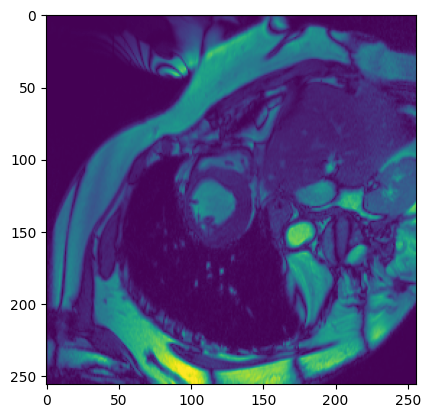

In [ ]:
temp = train_data.datas['x'][0].copy()
plt.imshow(train_data[idx][0].permute(1,2,0))
plt.show()

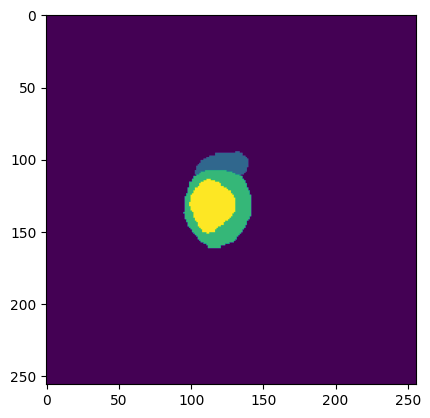

In [ ]:
plt.imshow(train_data[idx][1].permute(1,2,0)*50)
plt.show()

In [ ]:
val_data = MRIDataset('drive/MyDrive/training ED/val.pickle')

In [ ]:
train_data[idx][0].shape, val_data[idx][0].shape, train_data[idx][1].shape, val_data[idx][1].shape, train_data[idx][1].unique()

(torch.Size([1, 256, 256]),
 torch.Size([1, 256, 256]),
 torch.Size([1, 256, 256]),
 torch.Size([1, 256, 256]),
 tensor([0, 1, 2, 3]))

In [ ]:
import torch.nn as nn
import torch

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
    self.act1 = nn.ReLU()

    self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
    self.act2 = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)

    x = self.conv2(x)
    x = self.act2(x)

    return x

class UNET(nn.Module):
    def __init__(
            self, in_channels=1, out_channels=4, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [ ]:
#source https://github.com/hubutui/DiceLoss-PyTorch/blob/master/loss.py

import torch
import torch.nn as nn


class BinaryDiceLoss(nn.Module):
    def __init__(self, smooth:float=1, p:int=2, reduction:str='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction


    def forward(self, predict:torch.Tensor, target:torch.Tensor) -> torch.Tensor:
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))


class DiceLoss(nn.Module):
    def __init__(self, weight:torch.Tensor=None, ignore_index:int=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.kwargs = kwargs
        self.weight = weight
        self.ignore_index = ignore_index
        self.num_classes = weight.shape[0] if weight is not None else None


    def forward(self, predict:torch.Tensor, target:torch.Tensor) -> torch.Tensor:
        assert predict.shape == target.shape, 'predict & target shape do not match'
        dice = BinaryDiceLoss(**self.kwargs)
        total_loss = 0
        predict = torch.softmax(predict, dim=1)
        dice_scores = []

        for i in range(target.shape[1]):
            if i != self.ignore_index:
                dice_loss = dice(predict[:, i], target[:, i])
                if self.weight is not None:
                    assert self.weight.shape[0] == target.shape[1], \
                        'Expect weight shape [{}], get[{}]'.format(target.shape[1], self.weight.shape[0])
                    dice_loss *= self.weights[i]
                total_loss += dice_loss

        return total_loss/target.shape[1]

In [ ]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
EPOCHS = 200
LR = 3e-4
model_ckpt_path = "unet.pth"
BATCH_SIZE = 3
NUM_WORKERS = 2

In [ ]:
# def dice_score(preds, y, num_classes):
#     dice_scores = []
#     overall_dice_score = 0
#     for class_idx in range(num_classes):
#         pred = (preds[:, class_idx] > 0.5).float()
#         target = (y[:, class_idx] > 0.5).float()
#         dice_score_coef = (2 * (pred * target).sum()) / ((pred + target).sum() + 1e-8)
#         dice_scores.append(dice_score_coef.item())
#         overall_dice_score += dice_score_coef.item()
#     overall_dice_score /= num_classes
#     return dice_scores, overall_dice_score

import torch
from torch import Tensor

# def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
#     # Average of Dice coefficient for all batches, or for a single mask
#     assert input.size() == target.size()
#     assert input.dim() == 3 or not reduce_batch_first

#     sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

#     inter = 2 * (input * target).sum(dim=sum_dim)
#     sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
#     sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

#     dice = (inter + epsilon) / (sets_sum + epsilon)
#     return dice.mean()

# def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
#     return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)

# def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
#     # Dice loss (objective to minimize) between 0 and 1
#     fn = multiclass_dice_coeff if multiclass else dice_coeff
#     return 1 - fn(input, target, reduce_batch_first=True)

dice_loss = smp.losses.DiceLoss(mode='multiclass', ignore_index=0)

def train_step(train_loader, model, optimizer, num_classes, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.train()
    losses = 0
    dice_scores = [0] * num_classes  # Initialize dice scores for each class
    dice_coeff = torchmetrics.Dice(num_classes=4, average='samples', ignore_index=0).to(device)
    dice_coeff_per_class_function = torchmetrics.Dice(num_classes=4, average='none', ignore_index=0).to(device)
    # dice_coeff_per_class_function.reduce = 'none'
    overall_dice_score = 0
    class_dice_score = torch.zeros((4)).to(device)

    for data in train_loader:
        x, y = data
        x, y = x.to(device), y.to(device)

        pred = model(x)
        pred = torch.softmax(pred, dim=1)

        loss = dice_loss(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses += loss.item()
        # dice_scores_batch, overall_dice_score_batch = dice_score(pred, y, num_classes)  # Pass num_classes argument
        # for i, score in enumerate(dice_scores_batch):
        #     dice_scores[i] += score
        # overall_dice_score += overall_dice_score_batch

        # losses += loss.item()
        overall_dice_score += dice_coeff(pred, y.long())  # Pass num_classes argument
        dice_score_per_class = dice_coeff_per_class_function(pred, y.long())
        class_dice_score+=dice_score_per_class

    losses /= len(train_loader)
    # dice_scores = [score / len(train_loader) for score in dice_scores]
    overall_dice_score /= len(train_loader)
    class_dice_score/=len(train_loader)

    # return losses, dice_scores, overall_dice_score
    return losses, overall_dice_score.cpu().numpy(), class_dice_score.detach().cpu().numpy()

In [ ]:
def eval_step(eval_loader, model, num_classes, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    losses = 0
    dice_scores = [0] * num_classes  # Initialize dice scores for each class
    dice_coeff = torchmetrics.Dice(num_classes=4, average='samples', ignore_index=0).to(device)
    dice_coeff_per_class_function = torchmetrics.Dice(num_classes=4, average='none', ignore_index=0).to(device)
    overall_dice_score = 0
    class_dice_score = torch.zeros((4)).to(device)

    for data in eval_loader:
        with torch.no_grad():
            x, y = data
            x, y = x.to(device), y.to(device)

            pred = model(x)
            pred = torch.softmax(pred, dim=1)

            # loss = criterion(pred, y)
            loss = dice_loss(pred, y)

            losses += loss.item()
            # dice_scores_batch, overall_dice_score_batch = dice_score(pred, y, num_classes)  # Pass num_classes argument
            # for i, score in enumerate(dice_scores_batch):
            #     dice_scores[i] += score
            # overall_dice_score += overall_dice_score_batch

            # losses += loss.item()
            overall_dice_score += dice_coeff(pred, y.long())  # Pass num_classes argument
            dice_score_per_class = dice_coeff_per_class_function(pred, y.long())
            class_dice_score+=dice_score_per_class

    losses /= len(eval_loader)
    overall_dice_score /= len(eval_loader)
    class_dice_score/=len(eval_loader)

    return losses, overall_dice_score.cpu().numpy(), class_dice_score.detach().cpu().numpy()

In [ ]:
import time


In [ ]:
def train(device, model, train_dataloader, val_dataloader, optim, num_classes):
    model = model.to(device)
    best_loss = float("inf")

    start_time = time.time()  # Start measuring training time

    train_losses = []
    train_dice_scores = []
    eval_losses = []
    eval_dice_scores = []

    for epoch in range(EPOCHS):
        print(f"epoch: {epoch+1}")

        train_results = train_step(train_dataloader, model, optim, num_classes, device)
        train_loss = train_results[0]  # Extract the train_loss from the results
        # train_dice_scores = train_results[1]  # Extract the train_dice_scores from the results
        overall_train_dice_score = train_results[1]  # Extract the overall_train_dice_score from the results

        train_dice_score_per_class = train_results[2]
        print(f"Train Loss: {train_loss}, Train Overall Dice Score: {overall_train_dice_score}, Train Dice Score Per Class: {train_dice_score_per_class}")
        # print(f"Train Loss: {train_loss}, Train Dice Scores: {train_dice_scores},Train Overall Dice Score: {overall_train_dice_score}")

        eval_results = eval_step(val_dataloader, model,num_classes, device)
        eval_loss = eval_results[0]  # Extract the train_loss from the results
        # eval_dice_scores = eval_results[1]  # Extract the train_dice_scores from the results
        overall_eval_dice_score = eval_results[1]  # Extract the overall_train_dice_score from the results
        # print(f"Eval Loss: {eval_loss}, Eval Dice Scores: {eval_dice_scores}, Eval Overall Dice Score: {overall_eval_dice_score}")
        eval_dice_score_per_class = eval_results[2]
        print(f"Eval Loss: {eval_loss}, Eval Overall Dice Score: {overall_eval_dice_score}, Eval Dice Score Per Class: {eval_dice_score_per_class}")

        train_losses.append(train_loss)
        train_dice_scores.append(overall_train_dice_score)
        eval_losses.append(eval_loss)
        eval_dice_scores.append(eval_dice_scores)

        if eval_loss < best_loss:
            print(f"best eval loss: {eval_loss}")
            best_loss = eval_loss
            torch.save(model.state_dict(), model_ckpt_path)

    end_time = time.time()  # Stop measuring training time
    training_time = end_time - start_time
    print(f"Training Time: {training_time} seconds")

    # Plotting train and eval dice scores
    epochs = range(1, EPOCHS + 1)

    plt.plot(epochs, overall_train_dice_score, 'b', label='Train Dice Score')
    plt.plot(epochs, overall_eval_dice_score, 'r', label='Eval Dice Score')
    plt.title('Train and Eval Dice Scores')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.legend()
    plt.show()

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [ ]:
model = UNET(1,4)

model = model.to(DEVICE)
print( next(model.parameters()).device)
loss_fn = DiceLoss()


cuda:0


In [ ]:
LR

0.0003

In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
num_classes=4

In [ ]:
from time import sleep
import random

In [ ]:
train(DEVICE, model, train_dataloader, val_dataloader, optim,num_classes)

epoch: 1
Train Loss: 0.5008434506023631, Train Overall Dice Score: 0.0170974712818861, Train Dice Score Per Class: [       nan        nan 0.0270894  0.05956479]
Eval Loss: 0.5175341853728661, Eval Overall Dice Score: 0.012819888070225716, Eval Dice Score Per Class: [       nan        nan 0.02525028 0.        ]
best eval loss: 0.5175341853728661
epoch: 2
Train Loss: 0.5304076129314946, Train Overall Dice Score: 0.013637126423418522, Train Dice Score Per Class: [       nan        nan 0.02687402 0.        ]
Eval Loss: 0.5175341853728661, Eval Overall Dice Score: 0.012819888070225716, Eval Dice Score Per Class: [       nan        nan 0.02525028 0.        ]
epoch: 3
Train Loss: 0.5291144926758373, Train Overall Dice Score: 0.013642793521285057, Train Dice Score Per Class: [       nan        nan 0.02688224        nan]
Eval Loss: 0.5175341853728661, Eval Overall Dice Score: 0.012819888070225716, Eval Dice Score Per Class: [       nan        nan 0.02525028 0.        ]
epoch: 4
